In [1]:
# Machine Learning Library
import pandas as pd
import numpy as np
import pickle
import nltk
import re
from nltk.stem import PorterStemmer
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
plt.style.use('ggplot')

In [36]:
!pip install wordcloud

In [2]:
# Deep Learning Library
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

2024-08-12 10:27:31.640646: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Read the CSV file into a DataFrame
train_data = pd.read_csv("train.txt", header = None, sep=";", names=["Comment", "Emotion"], encoding="utf-8")

# Display the first few rows of the DataFrame to verify
print(train_data.head())

                                             Comment  Emotion
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger


In [7]:
train_data.shape

(16000, 2)

In [9]:
train_data.isnull().sum()

Comment    0
Emotion    0
dtype: int64

In [11]:
train_data.duplicated().sum()

1

## EDA

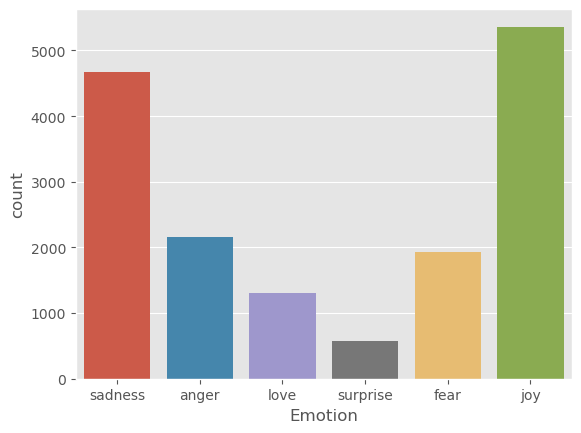

In [14]:
sns.countplot(x=train_data['Emotion'])
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


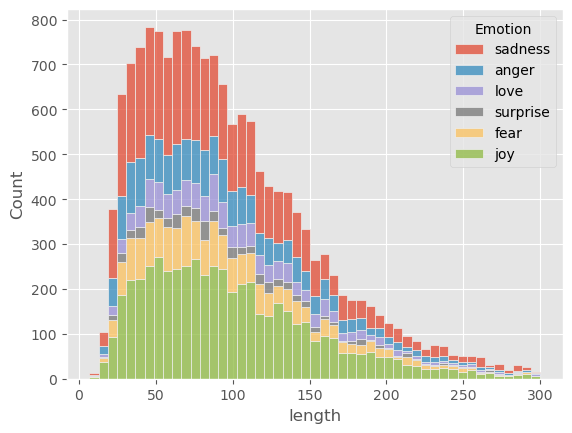

In [16]:
# Ctreate a copy of the train_data DataFrame

df2 = train_data.copy()
df2['length'] = [len(x) for x in train_data['Comment']]
length_value = df2['length'].values
sns.histplot(data=df2, x='length', hue='Emotion', multiple = 'stack')
plt.show()

## Data preprocessing
Label Encoding: It transforms categorical labels into integer values. This is useful for algorithms that require numerical input or for improving the performance of certain models.

In [19]:
# Initialize the LabelEncoder
lb = LabelEncoder()

# fit and transform the 'Emotion' column to numerical values
train_data['Emotion'] = lb.fit_transform(train_data['Emotion'])

# Display the first few rows of the transformed DataFrame to verify
print(train_data.head())

                                             Comment  Emotion
0                            i didnt feel humiliated        4
1  i can go from feeling so hopeless to so damned...        4
2   im grabbing a minute to post i feel greedy wrong        0
3  i am ever feeling nostalgic about the fireplac...        3
4                               i am feeling grouchy        0


## train_test_split:

Used for splitting a dataset into training and testing sets. CountVectorizer:

Converts a collection of text documents to a matrix of token counts (bag-of-words representation). TfidfVectorizer:

Converts a collection of text documents to a matrix of TF-IDF (Term Frequency-Inverse Document Frequency) features, which is a more informative representation than raw counts. MultinomialNB:

Multinomial Naive Bayes classifier, suitable for classification with discrete features (like word counts for text classification). LogisticRegression:

Logistic Regression classifier, useful for binary and multiclass classification tasks. RandomForestClassifier:

Random Forest classifier, an ensemble learning method that operates by constructing multiple decision trees during training and outputting the mode of the classes (classification) or mean prediction (regression) of the individual trees. SVC:

Support Vector Classifier, useful for classification tasks and can handle both linear and non-linear classification. accuracy_score:

Function to compute the accuracy of the predictions. classification_report:

Function to generate a detailed classification report, including precision, recall, F1-score, and support for each class.

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [24]:
df = train_data.copy()

In [26]:
df.head()

,Comment,Emotion
0,i didnt feel humiliated,4
1,i can go from feeling so hopeless to so damned...,4
2,im grabbing a minute to post i feel greedy wrong,0
3,i am ever feeling nostalgic about the fireplac...,3
4,i am feeling grouchy,0


In [28]:
"""tqdm to apply a progress bar to a text preprocessing function applied to a pandas DataFrame. This is useful for providing feedback during the execution of potentially time-consuming operations."""
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from tqdm import tqdm

In [30]:
# Enable Progress_apply with tqdm
tqdm.pandas()

# Dowload NLTK Stopwords
nltk.download('stopwords')
stopwords = (stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danielfusi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [32]:
# Define the text cleaning function
def clean_data(text):
    stemmer = PorterStemmer()
    text = re.sub("[^a-zA-Z]", " ", text)  # Remove non-alphabetic characters
    text = text.lower()  # Convert to lowercase
    text = text.split()  # Split into words
    text = [stemmer.stem(word) for word in text if word not in stopwords]  # Remove stopwords and apply stemming
    return " ".join(text)  # Join words back into a single string

# Display the first few rows of the DataFrame to verify
df['cleaned_comment']  = df['Comment'].progress_apply(clean_data)
# df['cleaned_comment']  = df['Comment'].apply(clean_data) 

100%|███████████████████████████████████| 16000/16000 [00:02<00:00, 5592.58it/s]


In [50]:
# split the dataset into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(df['cleaned_comment'], df['Emotion'], test_size = 0.2, random_state=42)

In [52]:
# Vectorize the test data using TfidfVectorizer
tfidfvectorizer = TfidfVectorizer()
X_train_tfidf = tfidfvectorizer.fit_transform(X_train)
X_test_tfidf = tfidfvectorizer.transform(X_test)

In [54]:
X_train_tfidf.shape

(12800, 9257)

In [66]:
classifier={
    'MultinomialNB':MultinomialNB(),
    'LogisticRegression':LogisticRegression(),
    'Random Forest':RandomForestClassifier(),
    'Support Vector Machine': SVC(),
}

for name,clf in classifier.items():
    print(f"\n============{name}============")
    clf.fit(X_train_tfidf, y_train)
    y_pred_tfidf = clf.predict(X_test_tfidf)
    accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
    print(f"======={accuracy_tfidf}============")
    print("Classification Report")
    print(classification_report(y_test, y_pred_tfidf))


============MultinomialNB============
=======0.655============
Classification Report
              precision    recall  f1-score   support

           0       0.93      0.31      0.46       427
           1       0.91      0.24      0.38       397
           2       0.58      0.98      0.73      1021
           3       1.00      0.03      0.06       296
           4       0.70      0.91      0.79       946
           5       1.00      0.01      0.02       113

    accuracy                           0.66      3200
   macro avg       0.85      0.41      0.41      3200
weighted avg       0.76      0.66      0.58      3200


============LogisticRegression============
=======0.829375============
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.79      0.83       427
           1       0.84      0.73      0.78       397
           2       0.78      0.94      0.85      1021
           3       0.80      0.49      0.61       296
      

In [68]:
lg = LogisticRegression()
lg.fit(X_train_tfidf, y_train)
lg_y_pred = lg.predict(X_test_tfidf)

In [94]:
def predict_emotion(input_text):
    cleaned_text = clean_data(input_text)
    input_vectorizer = tfidfvectorizer.transform([cleaned_text])

    predicted_label = lg.predict(input_vectorizer)[0]
    predicted_emotion = lb.inverse_transform([predicted_label])[0]
    label = np.max(lg.predict(input_vectorizer))

    return predicted_emotion, label

In [96]:
# Example Usage

input_text = "I feel so happy today!"
predicted_emotion = predict_emotion(input_text)
print("Predicted Emotion:", predicted_emotion)

Predicted Emotion: ('joy', 2)


# APPLYING DEEP LEARNING USING LSTM(LONG SHORT TERM MEMORY)

In [164]:
import pickle
pickle.dump(lg, open("logistic_regression.pkl","wb"))
pickle.dump(lb, open("label_encode.pkl","wb"))
pickle.dump(tfidfvectorizer, open("tfidfvectorizer.pkl","wb"))

### Word Encoding:

- It performs one-hot encoding for each word in the corpus using a vocabulary size of vocab_size.
- The one_hot function (presumably from Keras) is used for one-hot encoding.
- Each word in the corpus is converted to a list of integers representing its one-hot encoded vector.

### Padding Sequences:

- It pads the one-hot encoded sequences to have a fixed length of max_len.
- The pad_sequences function (presumably from Keras) is used for padding.
- Sequences are padded with zeros at the beginning (padding="pre").

In [116]:
def text_cleaning(df, column, vocab_size, max_len):
    stemmer = PorterStemmer()
    corpus = []
    for text in df[column]:
        # Clean the text
        text = re.sub("[^a-zA-Z]", " ", text)
        text = text.lower()
        text = text.split()
        text = [stemmer.stem(word) for word in text if word not in stopwords]
        text = " ".join(text)
        corpus.append(text)
    
    # One-hot encode the words in the corpus
    one_hot_word = [one_hot(input_text=word, n=vocab_size) for word in corpus]
    
    # Pad the sequences to have a fixed length
    pad = pad_sequences(sequences=one_hot_word, maxlen=max_len, padding="pre")
    
    return pad

In [118]:
# Preprocess the text data
x_train = text_cleaning(train_data, "Comment", vocab_size=11000, max_len=300)

# Prepare the labels using one-hot encoding
y_train = to_categorical(train_data["Emotion"])

In [124]:
# LSTM-Based neural network model using keras.

model = Sequential()
model.add(Embedding(input_dim = 11000, output_dim = 150, input_length = 300))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(64, activation = 'sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(6, activation = 'softmax'))
model.compile(optimizer='adam', loss = "categorical_crossentropy", metrics=['accuracy'])

callback = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
model.fit(x_train, y_train, epochs = 1, batch_size = 64, verbose = 1, callbacks=[callback])

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 61s 236ms/step - accuracy: 0.3320 - loss: 1.6271


/opt/anaconda3/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


#### Embedding Layer: 
This layer converts integer indices representing words into dense vectors of fixed size (output_dim). The input_length parameter specifies the length of input sequences.

#### Dropout Layers: 
Dropout is a regularization technique used to prevent overfitting by randomly setting a fraction of input units to zero during training.

#### LSTM Layer: 
Long Short-Term Memory (LSTM) is a type of recurrent neural network (RNN) architecture designed to learn long-term dependencies in sequential data. The LSTM layer has 128 units.

#### Dense Layers: 
These fully connected layers introduce non-linearity to the model. The first dense layer has 64 units with a sigmoid activation function, followed by a dropout layer. The second dense layer has 6 units (assuming it's a multi-class classification problem) with a softmax activation function to output class probabilities.

#### Compilation: 
The model is compiled with the Adam optimizer and categorical crossentropy loss function, suitable for multi-class classification. Accuracy is used as a metric to monitor during training.

#### Early Stopping Callback: 
The training process includes an early stopping callback, which monitors validation loss and stops training if the loss does not improve for a certain number of epochs (patience), restoring the best weights.

In [128]:
model.save("model.h5")

In [158]:
def predictive_system_dl(sentence):
    stemmer = PorterStemmer()
    corpus = []
    text = re.sub("[^a-zA-Z]", " ",sentence)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    text = " ".join(text)
    corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=11000) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word, maxlen=300, padding="pre")
    return pad

In [162]:
# Preprocess input text
cleaned_sentence = predictive_system_dl("I am feeling sad")

# Make prediction
predicted_probabilities = model.predict(cleaned_sentence)

# Get predicted class index and probability
predicted_index = np.argmax(predicted_probabilities)
predicted_probability = np.max(predicted_probabilities)

# Map predicted index to emotion label
predicted_emotion = lb.inverse_transform([predicted_index])[0]

# Print result
print(f"{predicted_emotion} with probability of {predicted_probability}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
sadness with probability of 0.6218442916870117


In [172]:
import pickle

# save the label ecoder
with open("lbl.pkl", "wb") as f:
    pickle.dump(lb, f)

# save vocabulary information
vocab_info = {"vocab_size": 11000, "max_len": 300}
with open("vocab_info.pkl", "wb") as f:
    pickle.dump(vocab_info, f)

"lb1.pkl" containing the label encoder (Lb).

"vocab_info.pkl" containg the vocabulary information dictionary(vocab_info).